In [2]:
import pandas as pd
closing_prices = pd.read_csv('../cryptoCompareData/btc_prices.csv')[['close','time']]
closing_prices['time'] = pd.to_datetime(closing_prices['time'])
social_data = pd.read_csv('../cryptoCompareData/btc_social.csv')

## speed constraints

<AxesSubplot:>

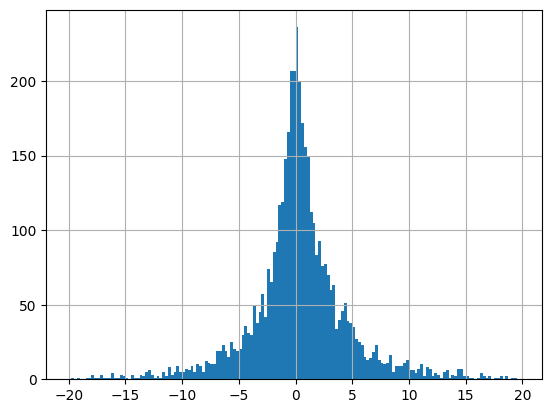

In [3]:
import numpy as np
closing_prices['pct_jumps'] = closing_prices['close'].pct_change()*100
closing_prices['pct_jumps'].hist(bins = np.arange(-20,20,0.25))

In [4]:
print(np.abs(closing_prices['pct_jumps']).describe())
print('85% quantile:',np.abs(closing_prices['pct_jumps']).quantile(0.85))

count    4389.000000
mean        3.323314
std         7.034972
min         0.000000
25%         0.675742
50%         1.761490
75%         4.074426
max       336.839004
Name: pct_jumps, dtype: float64
85% quantile: 5.887173360291639


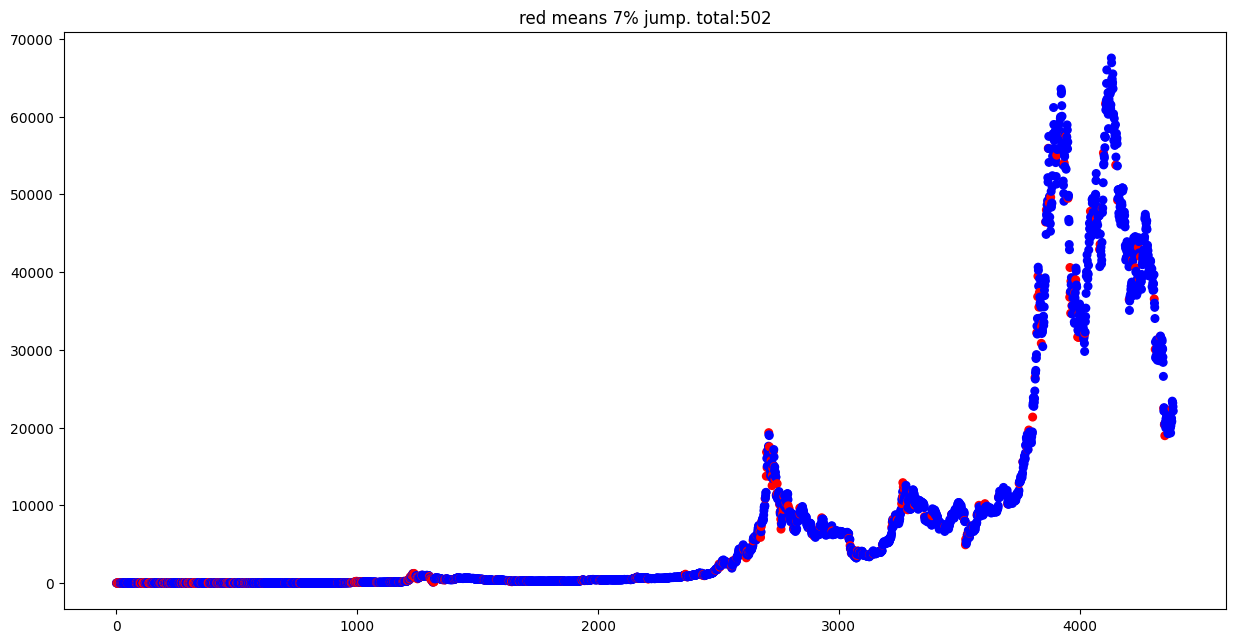

In [5]:
# 6-7% seems to be a good cutoff at first
import matplotlib.pyplot as plt
threshold = 7
jumps_7_pct = closing_prices.groupby(np.abs(closing_prices['pct_jumps']) >= threshold)
colors = ['blue' if i in jumps_7_pct.groups[False] else 'red' for i in closing_prices.index]
plt.figure(figsize=(15, 7.5))
plt.scatter(x=closing_prices.index,y=closing_prices['close'],color=colors,s=30)
plt.title(f'red means {threshold}% jump. total:'+str(len(jumps_7_pct.groups[True])));

#### if the tendency goes up and up like in timestamps ~3900 then its flagged as a jump although its just a strong upward tendency.
#### second derivative jumps are too noisy and there are too many big jumps.
#### lets see where the tweets of elon musk are located

In [6]:
musks = []
for year in range(2010,2023):
    df = pd.read_csv(f'../elonMuskTweets/{year}.csv')
    df = df.loc[df.tweet.str.lower().str.contains('bitcoin')]
    delta = pd.to_timedelta(df['timezone']//100,'h')
    df['date_to_tz'] = pd.to_datetime(df['date']) + delta
    if not df.empty:
        musks.append(df[['date','timezone','tweet','date_to_tz']])
musk = pd.concat(musks,axis=0).reset_index(drop=True)
musk['year'] = musk.date_to_tz.dt.year
musk['month'] = musk.date_to_tz.dt.month
musk['day'] = musk.date_to_tz.dt.day

Text(0.5, 1.0, 'musk tweets')

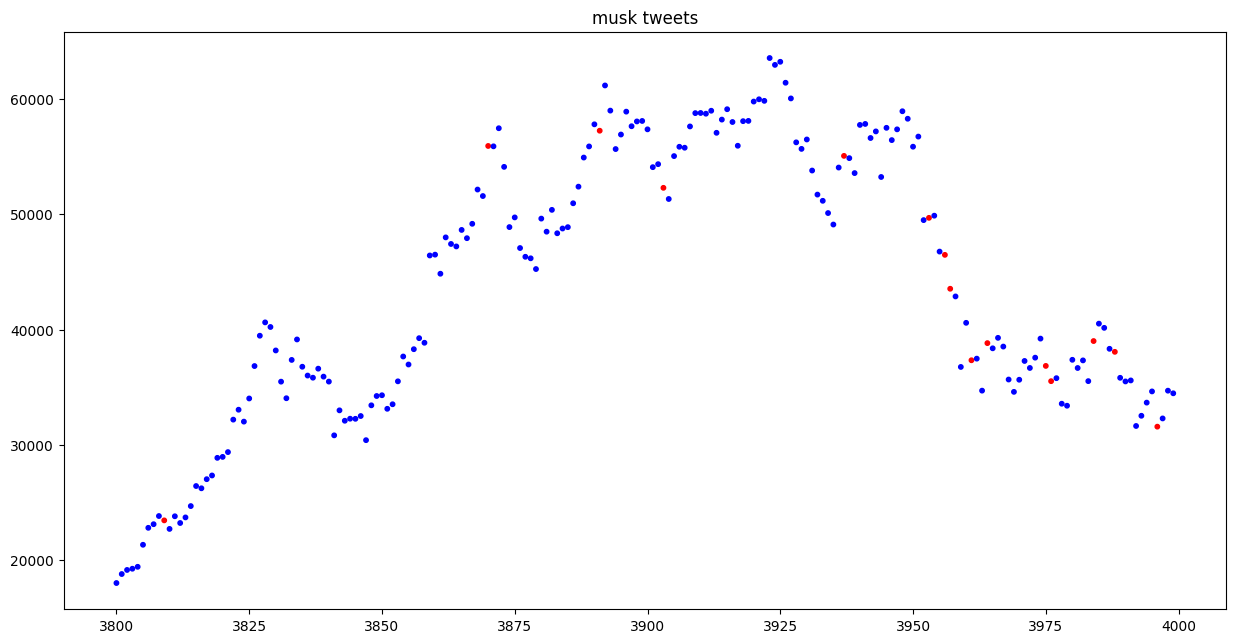

In [7]:
closing_prices['year'] = closing_prices.time.dt.year
closing_prices['month'] = closing_prices.time.dt.month
closing_prices['day'] = closing_prices.time.dt.day

closing_prices_musk = closing_prices.copy(deep=True)
closing_prices_musk['index'] = closing_prices_musk.index
closing_prices_musk = closing_prices_musk.merge(musk, on=['year','month','day'], how='inner')
closing_prices_musk.set_index('index')

show_from = 3800
show_till = 4000

colors = ['red' if i in closing_prices_musk['index'].values else 'blue' for i in closing_prices.index]
s = [20 if i in closing_prices_musk.index else 10 for i in closing_prices.index]
plt.figure(figsize=(15, 7.5))
plt.scatter(x=closing_prices.index[show_from:show_till],y=closing_prices['close'][show_from:show_till],color=colors[show_from:show_till],s=s[show_from:show_till])
plt.title(f'musk tweets')

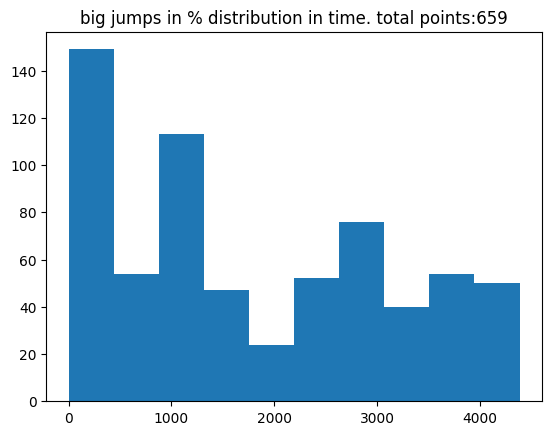

In [8]:
import numpy as np
import matplotlib.pyplot as plt
quantile = np.abs(closing_prices['pct_jumps']).quantile(0.85)
jumps = closing_prices['pct_jumps'][np.abs(closing_prices['pct_jumps']) > quantile]
jump_indices = jumps.index
plt.hist(jump_indices)
plt.title('big jumps in % distribution in time. total points:'+str(len(jump_indices)));

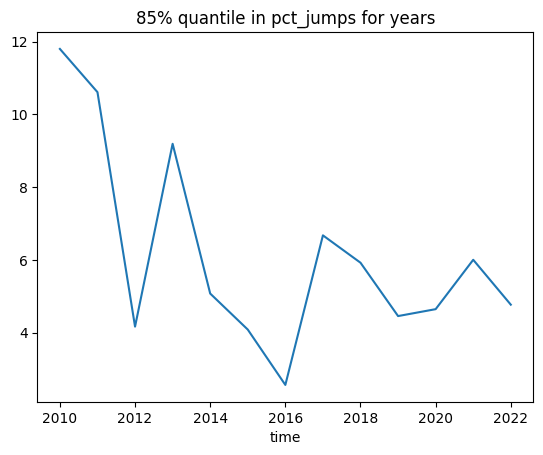

In [9]:
abs_pct_changes = closing_prices.loc[:,['pct_jumps','time']]
abs_pct_changes['pct_jumps'] = np.abs(abs_pct_changes['pct_jumps'])
quantiles_per_year =  abs_pct_changes.groupby(abs_pct_changes.time.dt.year)['pct_jumps'].quantile(0.85)
quantiles_per_year.plot(title='85% quantile in pct_jumps for years');

#### lets try to filter with social data

<AxesSubplot:>

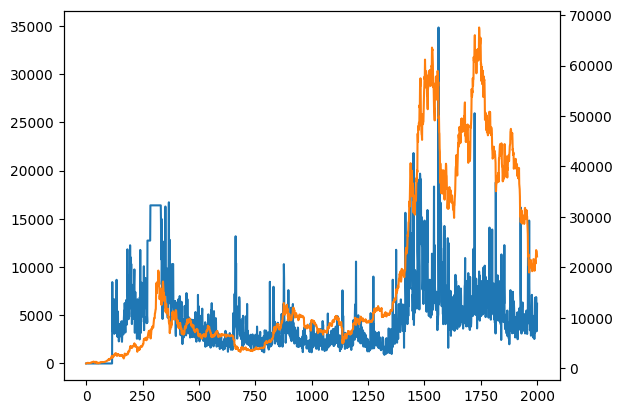

In [10]:
social_data['reddit_comments_per_day'].plot()
closing_prices['close'].iloc[-len(social_data['reddit_comments_per_day']):].reset_index(drop=True).plot(secondary_y=True)

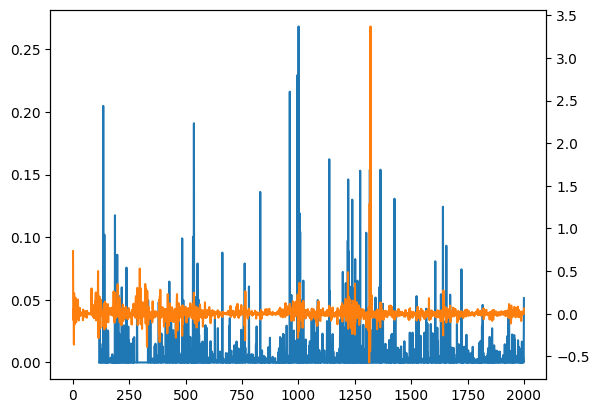

In [11]:
social_data['time'] = pd.to_datetime(social_data['time'])
closing_prices['time'] = pd.to_datetime(closing_prices['time'])
df = pd.merge(closing_prices,social_data,on='time',how='inner')
df['comments_pct'] = social_data['reddit_comments_per_day'].pct_change()
df['abs_pct_price'] = closing_prices['close'].pct_change()

#lets try to filter for big jumps in both:

ax1 = (df['comments_pct'].clip(lower=0) * np.abs(df['abs_pct_price'])).plot(label='comments_pct * price_change')
ax2 = df['abs_pct_price'].reset_index(drop=True).plot(secondary_y=True,label='price absolute % change')

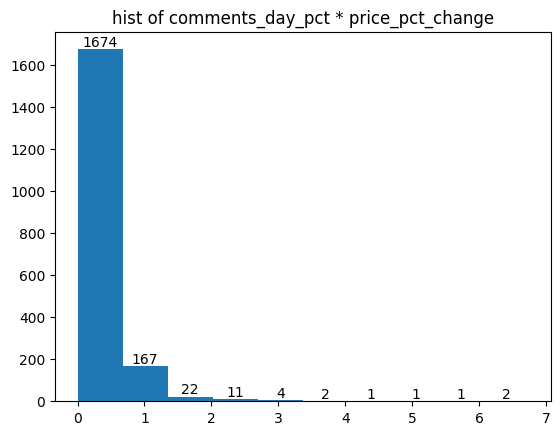

In [12]:
df['weighted prices'] = (df['comments_pct'].clip(lower=0) + 2 * np.abs(df['abs_pct_price'])).sort_values(ascending=False)
top_multiplied = df['weighted prices'].sort_values(ascending=False)
counts, edges, bars = plt.hist(df['weighted prices'].replace(np.inf,0))
plt.title('hist of comments_day_pct * price_pct_change')
plt.bar_label(bars);

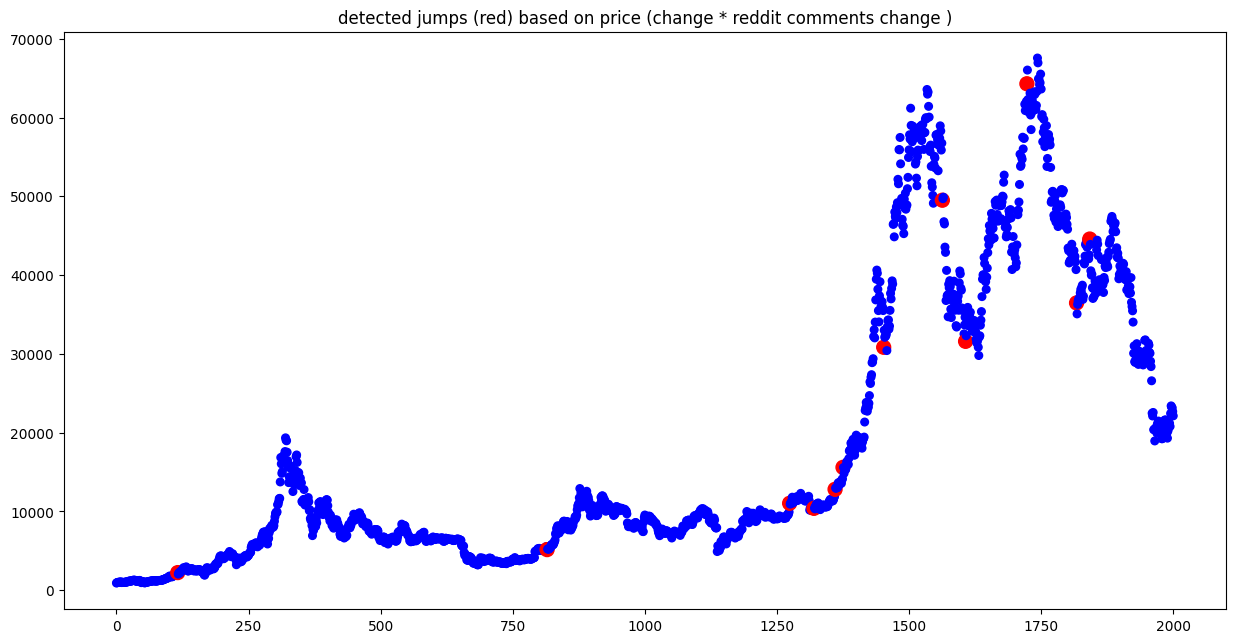

In [13]:
color_result_above = 2.75

colors = ['red' if i in top_multiplied[top_multiplied > color_result_above].index else 'blue' for i in df['close'].index]
sizes = [100 if i in top_multiplied[top_multiplied > color_result_above].index else 30 for i in df['close'].index]
plt.figure(figsize=(15, 7.5))
plt.scatter(x=df['close'].index,y=df['close'],color=colors,s=sizes)
plt.title('detected jumps (red) based on price (change * reddit comments change )');

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


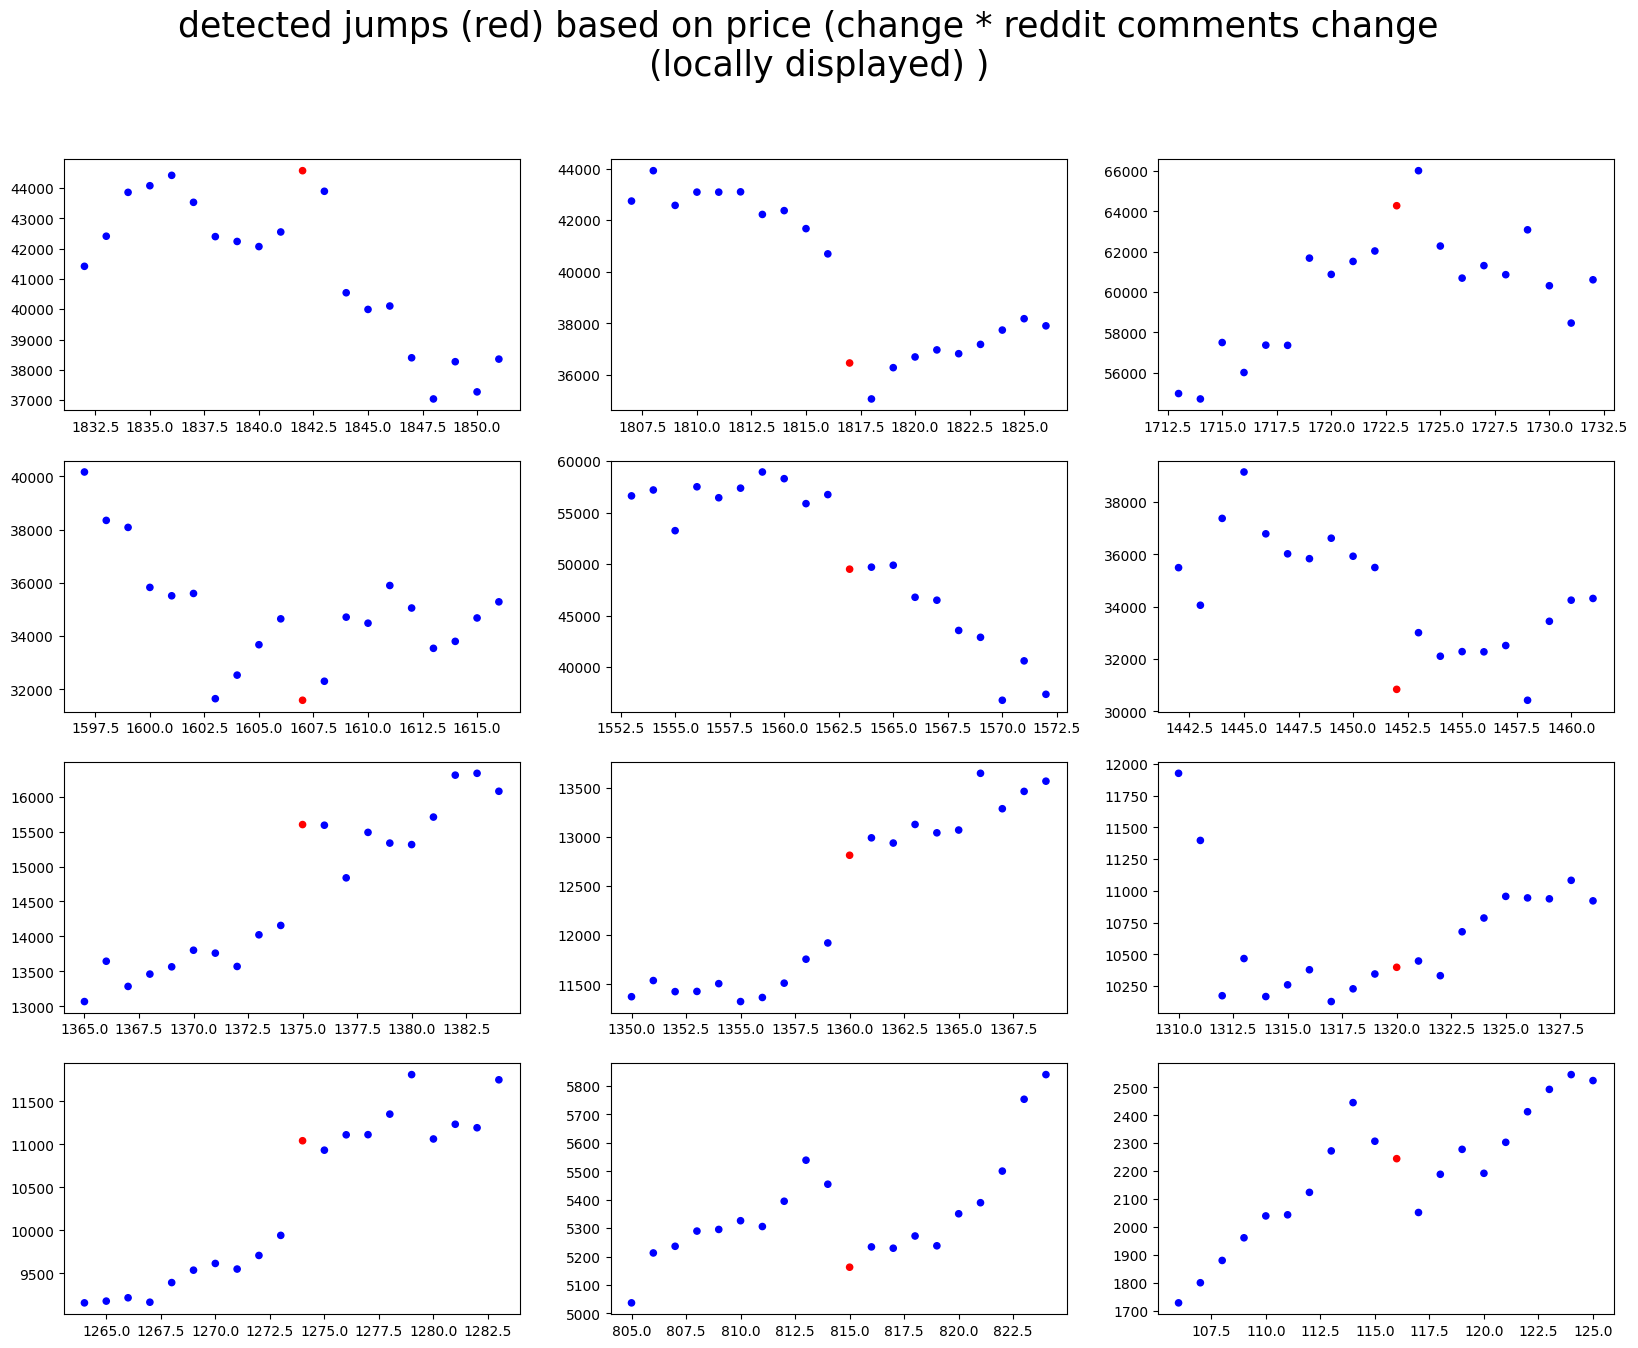

In [14]:
red_points = df[top_multiplied > color_result_above].sort_values('time',ascending=False)
fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(20,15))

c = 0
for row in axes:
    for ax in row:
        idx = red_points.index.tolist()[c]
        segment = df.iloc[idx-10:idx+10]
        colors = ['red' if i in red_points.index else 'blue' for i in segment.index]
        ax.scatter(x=segment['close'].index,y=segment['close'],color=colors,s=20)
        c+=1
plt.suptitle('detected jumps (red) based on price (change * reddit comments change \n (locally displayed) )',fontsize=25);

##### top ~10 values seem to be anomalies indeed (above that there are more and more (seemingly) false positives

### TEST transformer

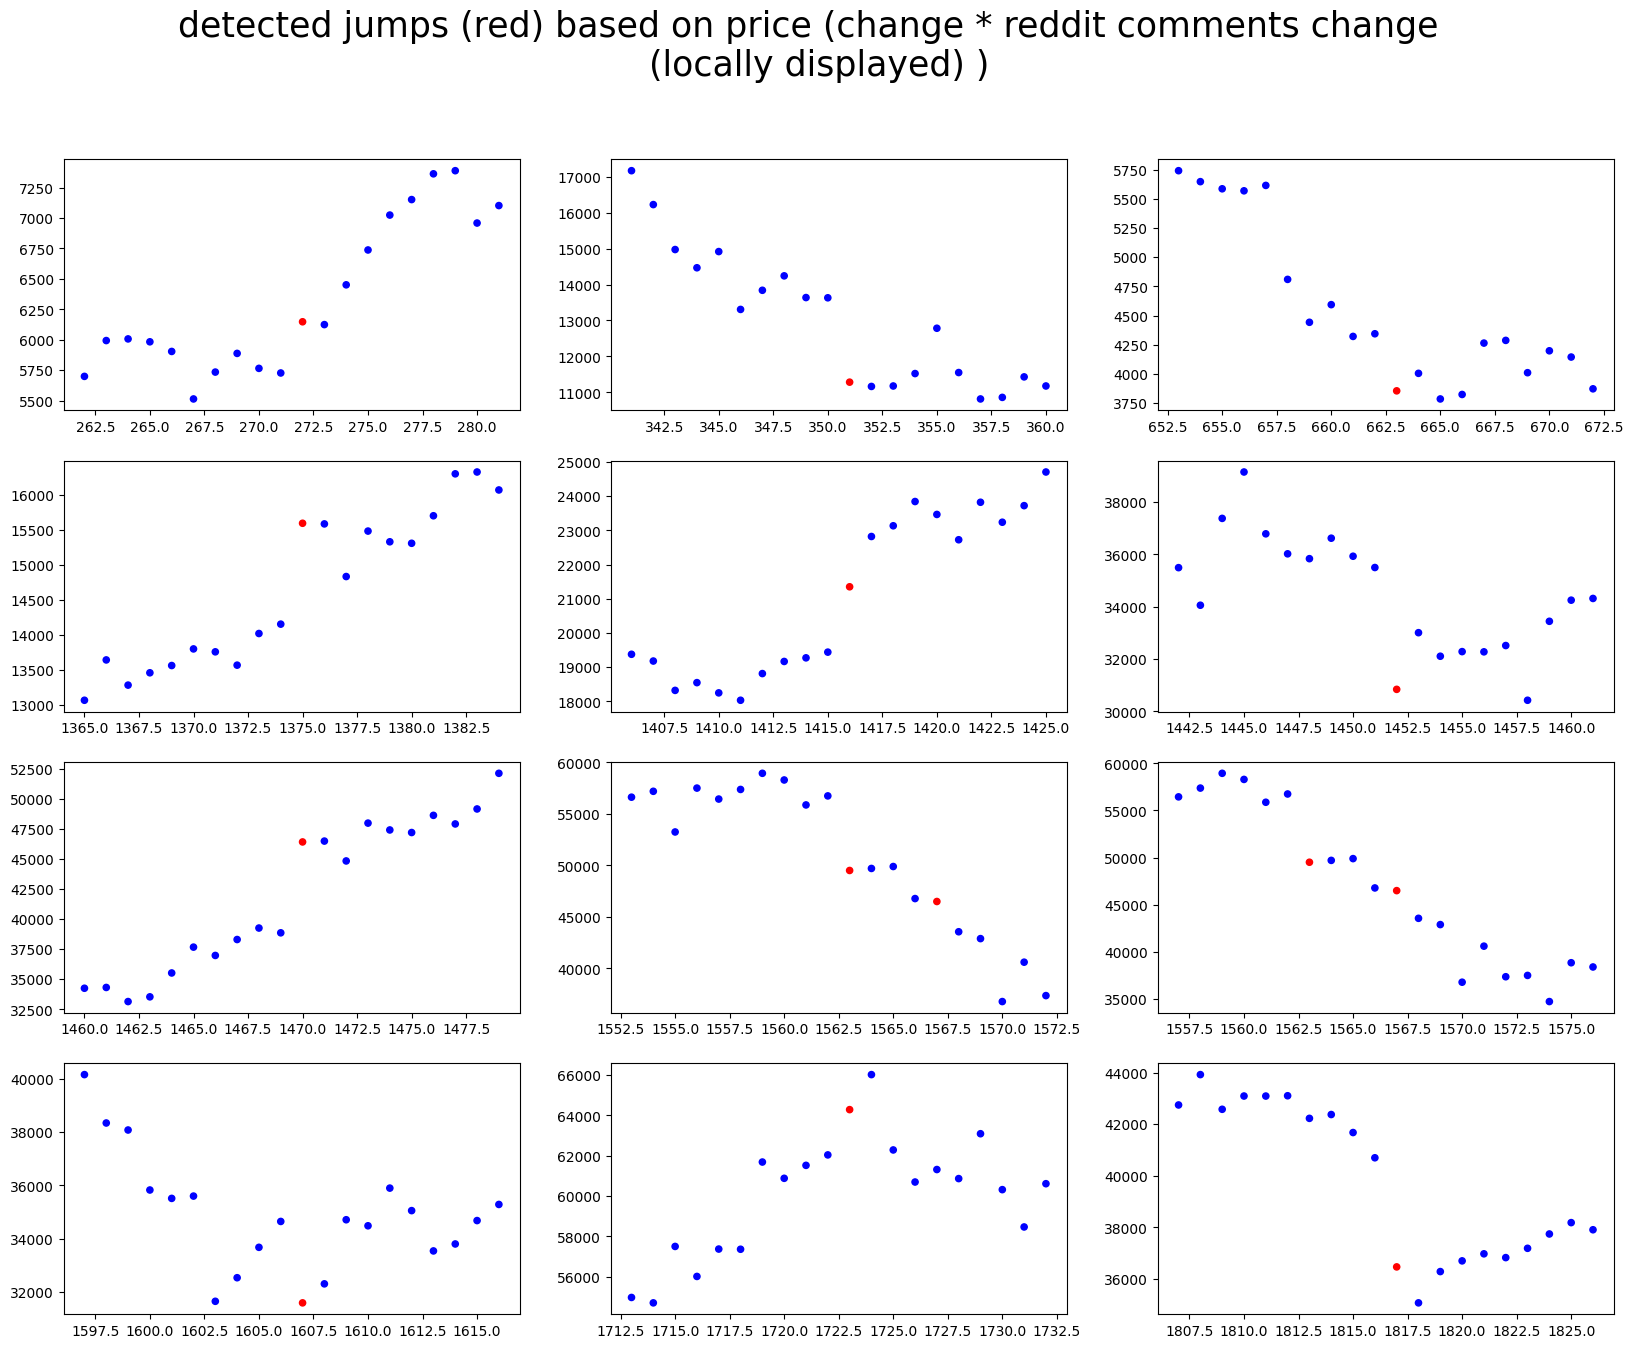

In [31]:
import _preprocessing
import importlib
importlib.reload(_preprocessing)

detector = _preprocessing.ManualValidTargetDetector(invalidate_top_x_percent=0.7)
df = detector.fit_transform(df)

red_points = df[~df['is_valid_target']]
fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(20,15))

c = 0
for row in axes:
    for ax in row:
        idx = red_points.index.tolist()[c]
        segment = df.iloc[idx-10:idx+10]
        colors = ['red' if i in red_points.index else 'blue' for i in segment.index]
        ax.scatter(x=segment['close'].index,y=segment['close'],color=colors,s=20)
        c+=1
plt.suptitle('detected jumps (red) based on price (change * reddit comments change \n (locally displayed) )',fontsize=25);

In [32]:
len(red_points)

14